In [57]:
"""
Nonhydrostaticmodel, with buoyancy as tracer(:b) and tracer(:c) and Lagrangian particles all data except halo regions 
10.3.2022
Si Chen

"""

"Nonhydrostaticmodel, with buoyancy as tracer(:b) and tracer(:c) and Lagrangian particles all data except halo regions \n10.3.2022\nSi Chen\n\n"

In [58]:
using Random
using Printf
using Plots
using JLD2
using Statistics

using Oceananigans
using Oceananigans.Advection
using Oceananigans.Operators
using Oceananigans.Fields: ZeroField
using Oceananigans.Fields: BackgroundFields, Field, tracernames, VelocityFields, TracerFields, PressureFields
using Oceananigans.Units: minute, minutes, hour, hours

In [59]:
Nx = 32
Ny = 32
Nz = 24          # number of points in the vertical direction
Lx = 64          
Ly = 64          
Lz = 32          # (m) domain depth


"""

refinement = 1.2 # controls spacing near surface (higher means finer spaced)
stretching = 12  # controls rate of stretching at bottom

# Normalized height ranging from 0 to 1
h(k) = (k - 1) / Nz

# Linear near-surface generator
ζ₀(k) = 1 + (h(k) - 1) / refinement

# Bottom-intensified stretching function
Σ(k) = (1 - exp(-stretching * h(k))) / (1 - exp(-stretching))

# Generating function
z_faces(k) = Lz * (ζ₀(k) * Σ(k) - 1)
"""
grid = RectilinearGrid(size = (Nx, Ny, Nz),
                          x = (0, Lx),   #  Nx*Δx
                          y = (0, Ly),   # Ny*Δy
                          z = (-Lz,0))   # z_faces

grid

In [60]:
"""
plot(grid.Δzᵃᵃᶜ[1:grid.Nz], grid.zᵃᵃᶜ[1:grid.Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Vertical spacing (m)",
     legend = nothing)
"""

"plot(grid.Δzᵃᵃᶜ[1:grid.Nz], grid.zᵃᵃᶜ[1:grid.Nz],\n     marker = :circle,\n     ylabel = \"Depth (m)\",\n     xlabel = \"Vertical spacing (m)\",\n     legend = nothing)\n"

## Lagrangian particles

In [61]:
n_particles = 10;
x₀ = Lx*rand(n_particles);  #125*rand(n_particles);
y₀ = Ly*rand(n_particles);
z₀ = -Lz*rand(n_particles);  #0*ones(n_particles)

lagrangian_particles = LagrangianParticles(x=x₀, y=y₀, z=z₀, restitution=0)

10 Lagrangian particles with
├── 3 properties: (:x, :y, :z)
└── 0 tracked fields: ()

# Boundary conditions
### No Particle boundary conditions

In [62]:
u₁₀ = 0.00001    # m s⁻¹, average wind velocity 10 meters above the ocean
cᴰ = 2.5e-3 # dimensionless drag coefficient
ρₒ = 1026 # kg m⁻³, average density at the surface of the world ocean
ρₐ = 1.225  # kg m⁻³, average density of air at sea-level

Qᵘ = - ρₐ / ρₒ * cᴰ * u₁₀ * abs(u₁₀) # m² s⁻²   kinematic stress: stress divided by density 

u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition
├── east: DefaultBoundaryCondition
├── south: DefaultBoundaryCondition
├── north: DefaultBoundaryCondition
├── bottom: DefaultBoundaryCondition
├── top: FluxBoundaryCondition: -2.98489e-16
└── immersed: FluxBoundaryCondition: Nothing

In [63]:
B₀ = 4.24e-8    #m²s⁻³  B₀ = -4.24e-8  
N² = 9e-6    #dbdz=N^2, s⁻²
buoyancy_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(B₀),
                                       bottom = GradientBoundaryCondition(N²))
#https://clima.github.io/OceananigansDocumentation/stable/generated/convecting_plankton/
#=

The flux convention in Oceananigans.jl
Fluxes are defined by the direction a quantity is carried: positive velocities produce positive fluxes, while negative velocities produce negative fluxes. 
Diffusive fluxes are defined with the same convention. 
A positive flux at the top boundary transports buoyancy upwards, out of the domain. 
This means that a positive flux of buoyancy at the top boundary reduces the buoyancy of near-surface fluid, causing convection.

=#

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition
├── east: DefaultBoundaryCondition
├── south: DefaultBoundaryCondition
├── north: DefaultBoundaryCondition
├── bottom: GradientBoundaryCondition: 9.0e-6
├── top: FluxBoundaryCondition: 4.24e-8
└── immersed: FluxBoundaryCondition: Nothing


## Forcing

https://github.com/CliMA/Oceananigans.jl/blob/main/src/Grids/rectilinear_grid.jl 


https://github.com/CliMA/Oceananigans.jl/blob/main/src/Grids/zeros.jl

div_Uc 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/tracer_advection_operators.jl

δzᵃᵃᶜ 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Operators/difference_operators.jl

advective_tracer_flux_z 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/centered_advective_fluxes.jl 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/centered_second_order.jl

In [64]:
# Add an extra advection term to the tracer equation to account for a 'slip' velocity

ws = 0.001;   # slip velocity (in m/s)
λ = 1;      # 2 decay length of slip velocity at z=0 (m)，Si:deeper than this, slip velocity is very close to ws.
# create an empty array to store the slip velocity (this is a tuple)
slip_vel = (u=zeros(0:Nx+2,0:Ny+2,0:Nz+2),v=zeros(0:Nx+2,0:Ny+2,0:Nz+2),w=zeros(0:Nx+2,0:Ny+2,0:Nz+2))
# because div_Uc is 3D, so slip_vel has to be defined 3D.
# zeros function in Oceananigans is different in Julia because in Julia zeros(0:2) erros.
# to learn the dimensions and indices see the following  
# when build it has with 1×1×1 halo, after calculation, it has 3×3×3 halo, actuall 3 in both sides of each direction  

# define the non-zero components(s) of the slip velocity
# to conserve mass, the slip velocity should =0 at z=0
# The width of the tanh will depend on the advection scheme and integrated tracer conservation should be checked
for k=0:Nz+2
  #slip_vel.w[:,:,k].+=ws*tanh(max((-grid.zᵃᵃᶠ[k]-5)/λ,0));   # don't need .+=  this "+"
    
    #slip_vel.w[:,:,k].=grid.zᵃᵃᶠ[k] > -Lz/2 ? ws*tanh(max(-grid.zᵃᵃᶠ[k]-depth_zero,0)/λ) : ws*tanh(max(Lz + grid.zᵃᵃᶠ[k] - depth_zero,0)/λ)   
    slip_vel.w[:,:,k].+=ws*(tanh(max(-grid.zᵃᵃᶠ[k]/λ,0))*tanh(max((grid.zᵃᵃᶠ[k]+Lz)/λ,0)));
    
    
    # max means that for those smaller than 0, set to zeros.   
    #ttps://baike.baidu.com/item/%E5%AF%B9%E7%A7%B0%E5%8F%98%E6%8D%A2/4729638
    #y=f(2a－x)  and y=f(x) is symmetric around x=a
end

# define the RHS forcing term for advection by the slip velocity using the inbuilt advection operator
# Different advection schemes can be specified here

slip_advection(i, j, k, grid, clock, model_fields) = - div_Uc(i,j,k,grid,CenteredSecondOrder(),slip_vel,model_fields.c)  

#slip_advection(i, j, k, grid, clock, model_fields) = - div_Uc(i,j,k,grid,WENO5(grid = grid),slip_vel,model_fields.c)  

# @inline div_Uc(i, j, k, grid, ::Nothing, U, c) = zero(eltype(grid)) seems like it's ok without advection argument
#https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/tracer_advection_operators.jl


# because div_Uc is 3D, so slip_vel has to be defined 3D. 
# see: /src/Advection/centered_second_order.jl here it also defined a constant: const C2 = CenteredSecondOrder L14
# try different scheme like WENO5 https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/weno_fifth_order.jl

slip_forcing = Forcing(slip_advection, discrete_form=true)

#see: https://clima.github.io/OceananigansDocumentation/stable/model_setup/forcing_functions/
    # 1 Forcing functions with external parameters means only influencing x,y,z,t
    # 2 Forcing functions that depend on model fields means may influence u,v,w,S,T, etc.  
    # 3 "Discrete form" forcing functions means by using model_fields argument, it can access all the model field data u,v,w, 
         # and all tracers through like model_fields.b, model_fields.u, model_fields.c  , etc. 
    # "Discrete form" forcing functions




DiscreteForcing{Nothing}
├── func: slip_advection (generic function with 1 method)
└── parameters: nothing

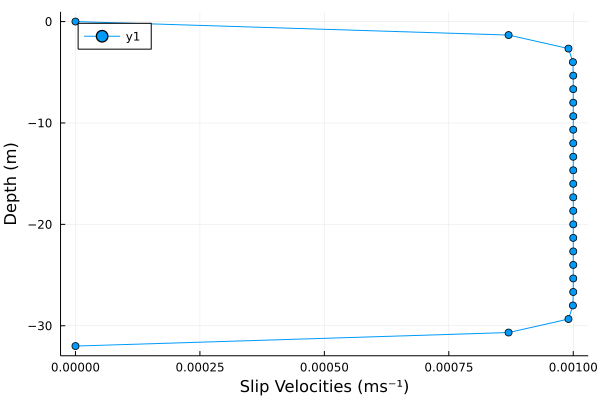

In [65]:
plot(slip_vel.w[1,1,1:Nz+1],grid.zᵃᵃᶠ[1:Nz+1],        #1:Nz+1
    marker = :circle,
    ylabel = "Depth (m)",
    xlabel = "Slip Velocities (ms⁻¹)",
    legend=:topleft)

# Model instantiation

In [66]:
model = NonhydrostaticModel(
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            grid = grid,
                            tracers = (:b,:c),                        
                            coriolis = FPlane(f=1e-4),
                            buoyancy = BuoyancyTracer(),
                            particles = lagrangian_particles,
                            closure = AnisotropicMinimumDissipation(),
                            forcing = (c=slip_forcing,),
                            #boundary_conditions = (b=buoyancy_bcs,))
                            boundary_conditions = (u=u_bcs, b=buoyancy_bcs))  # the order shouldnt be changed 

┌ Warning: Inflating model grid halo size to (3, 3, 3) and recreating grid. The model grid will be different from the input grid. To avoid this warning, pass halo=(3, 3, 3) when constructing the grid.
└ @ Oceananigans.Models.NonhydrostaticModels /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Models/NonhydrostaticModels/nonhydrostatic_model.jl:147


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 32×32×24 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo
├── timestepper: RungeKutta3TimeStepper
├── tracers: (b, c)
├── closure: AnisotropicMinimumDissipation{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, NamedTuple{(:b, :c), Tuple{Float64, Float64}}, Float64, Nothing}
├── buoyancy: BuoyancyTracer with -ĝ = ZDirection
├── coriolis: FPlane{Float64}(f=0.0001)
└── particles: 10 Lagrangian particles with 3 properties: (:x, :y, :z)

# Initial conditions

https://juliacn.gitlab.io/JuliaZH.jl/manual/functions.html

https://clima.github.io/OceananigansDocumentation/stable/generated/convecting_plankton/

In [67]:
# Random noise damped at top and bottom
Ξ(z) = randn() * z / model.grid.Lz * (1 + z / model.grid.Lz) # noise

# Velocity initial condition: random noise scaled by the friction velocity.
uᵢ(x, y, z) = sqrt(abs(Qᵘ)) * 1e-3 * Ξ(z)

cᵢ(x, y, z) = exp(z/10)

mixed_layer_depth = -20  # m
∂b∂z(z) = z > mixed_layer_depth ? 0 : N²   # https://juliacn.gitlab.io/JuliaZH.jl/manual/functions.html

b₀(x, y, z) = ∂b∂z(z) * z 
#https://clima.github.io/OceananigansDocumentation/stable/generated/convecting_plankton/

set!(model, u=uᵢ, w=uᵢ, b=b₀, c=cᵢ)
#set!(model, b=b₀, c=cᵢ)

# Setting up a simulation

https://github.com/CliMA/Oceananigans.jl/blob/main/src/Simulations/time_step_wizard.jl

https://github.com/CliMA/Oceananigans.jl/blob/fdddf1a0d2e3434ef9f05c6ae2d64d0edabceb38/src/Simulations/simulation.jl#L111-L115


In [68]:
#simulation = Simulation(model, Δt=10.0, stop_time=60minutes)  # Simulation(model, Δt=10.0, stop_time=60minutes)

simulation = Simulation(model, Δt=2minutes, stop_time=4hours)

wizard = TimeStepWizard(cfl=1.0, max_change=1.1, max_Δt=2minute)

simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(10))


"""
julia> simulation = Simulation(model, Δt=0.9, stop_iteration=100)
julia> wizard = TimeStepWizard(cfl=0.2)
julia> simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(4))

Then when `run!(simulation)` is invoked, the time-step `simulation.Δt` will be updated every 4 iterations.
Note that the name `:wizard` is unimportant.
"""


"julia> simulation = Simulation(model, Δt=0.9, stop_iteration=100)\njulia> wizard = TimeStepWizard(cfl=0.2)\njulia> simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(4))\n\nThen when `run!(simulation)` is invoked, the time-step `simulation.Δt` will be updated every 4 iterations.\nNote that the name `:wizard` is unimportant.\n"

In [69]:
# Print a progress message
progress_message(sim) = @printf("Iteration: %04d, time: %s, Δt: %s, max(|w|) = %.1e ms⁻¹, wall time: %s\n",
                                iteration(sim),
#src/Simulations/simulation.jl#L111-L115
                                prettytime(sim),
                                prettytime(sim.Δt),
                                maximum(abs, sim.model.velocities.w),
                                prettytime(sim.run_wall_time))
#prettytime: Convert a floating point value to a more human-friendly formatted string with three decimal places.
# also a generic function 
simulation.callbacks[:progress] = Callback(progress_message, IterationInterval(10))

Callback of progress_message on IterationInterval(10)

# output

https://docs.juliahub.com/Oceananigans/hU93i/0.45.2/library/#Oceananigans.OutputWriters.JLD2OutputWriter
 https://github.com/CliMA/Oceananigans.jl/blob/fdddf1a0d2e3434ef9f05c6ae2d64d0edabceb38/src/OutputWriters/jld2_output_writer.jl

In [70]:
# Create a NamedTuple with eddy viscosity
eddy_viscosity = (; νₑ = model.diffusivity_fields.νₑ)

simulation.output_writers[:slices] =
    JLD2OutputWriter(model, merge(model.velocities, model.tracers, eddy_viscosity),
                           prefix = "ocean_wind_mixing_and_convection_BuoyancyPlusTracerPlusLagrangian",
                     #field_slicer = FieldSlicer(j=Int(grid.Ny/2)), #here save only along y direction
                        #field_slicer = FieldSlicer(),   #include all data except halo retions
                          indices = (:, :, :), 
                        with_halos = false,
    
# field_slicer = nothing` means no slicing occurs, so that all field data, including halo regions, is saved.
#Default: FieldSlicer(), which slices halo regions. 
#FieldSlicer() Si: only grid includes halos,+-3,and u,v,w, and all field data don't include halo. 
#don't forget z include lower bound but face and center have different dimensions.
                         schedule = TimeInterval(1minute),
                            force = true)

simulation.output_writers[:particles] = JLD2OutputWriter(model, (particles=model.particles,), 
                               prefix = "particles",
                             schedule = TimeInterval(1minute),
                               force = true)


JLD2OutputWriter scheduled on TimeInterval(1 minute):
├── filepath: ./particles.jld2
├── 1 outputs: particles
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [71]:
run!(simulation)   # Δt is changing.

Iteration: 0000, time: 0 seconds, Δt: 2 minutes, max(|w|) = 1.2e-11 ms⁻¹, wall time: 0 seconds
Iteration: 0010, time: 10 minutes, Δt: 2 minutes, max(|w|) = 3.1e-11 ms⁻¹, wall time: 5.658 seconds
Iteration: 0020, time: 20 minutes, Δt: 2 minutes, max(|w|) = 3.7e-10 ms⁻¹, wall time: 7.639 seconds
Iteration: 0030, time: 30 minutes, Δt: 2 minutes, max(|w|) = 4.2e-09 ms⁻¹, wall time: 9.624 seconds
Iteration: 0040, time: 40 minutes, Δt: 2 minutes, max(|w|) = 4.8e-08 ms⁻¹, wall time: 11.643 seconds
Iteration: 0050, time: 50 minutes, Δt: 2 minutes, max(|w|) = 5.6e-07 ms⁻¹, wall time: 13.571 seconds
Iteration: 0060, time: 1 hour, Δt: 2 minutes, max(|w|) = 6.4e-06 ms⁻¹, wall time: 15.505 seconds
Iteration: 0070, time: 1.167 hours, Δt: 2 minutes, max(|w|) = 7.4e-05 ms⁻¹, wall time: 17.428 seconds
Iteration: 0080, time: 1.333 hours, Δt: 2 minutes, max(|w|) = 7.4e-04 ms⁻¹, wall time: 19.406 seconds
Iteration: 0090, time: 1.500 hours, Δt: 2 minutes, max(|w|) = 4.4e-03 ms⁻¹, wall time: 21.325 seconds


┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:167
┌ Info:     ... simulation initialization complete (195.895 ms)
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:202
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:112
┌ Info:     ... initial time step complete (3.406 seconds).
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Simulations/run.jl:119
┌ Info: Simulation is stopping. Model time 4 hours has hit or exceeded simulation stop time 4 hours.
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/JIHfS/src/Simulations/simulation.jl:165


## Visualization

In [72]:
""" Returns colorbar levels equispaced between `(-clim, clim)` and encompassing the extrema of `c`. """
function divergent_levels(c, clim, nlevels=21) 
    # the input clim is only one number,divergent_levels is for those the output is 
    # symmetric(on positive and negative sides), like velocity
    cmax = maximum(abs, c)  
    #Compute the maximum value by calling the function abs on each element of c over the given dimensions.
    # i.e. calculate abs first than max
    levels = clim > cmax ? range(-clim, stop=clim, length=nlevels) : range(-cmax, stop=cmax, length=nlevels)
    return (levels[1], levels[end]), levels
end

""" Returns colorbar levels equispaced between `clims` and encompassing the extrema of `c`."""
function sequential_levels(c, clims, nlevels=20)
        # the input clims is a range, sequential_levels is for those the output is 
        # nonsymmetric(on positive and negative sides), like scalars 
    levels = range(clims[1], stop=clims[2], length=nlevels)
    cmin, cmax = minimum(c), maximum(c)
    cmin < clims[1] && (levels = vcat([cmin], levels)) 
    cmax > clims[2] && (levels = vcat(levels, [cmax]))
    return (levels[1], levels[end]), levels    # I think the return should like this
    #return clims, levels
end

sequential_levels

In [73]:
# Coordinate arrays
xw, yw, zw = nodes(model.velocities.w)  #there is no real practical data in “model”, just the structure
xb, yb, zb = nodes(model.tracers.b)   # velocity field is located on Face while scalar is located on Center

# Open the file with our data
file = jldopen(simulation.output_writers[:slices].filepath)

# Extract a vector of iterations
iterations = parse.(Int, keys(file["timeseries/t"])) # turn an array of strings into numbers 

times = [file["timeseries/t/$iter"] for iter in iterations]
intro = searchsortedfirst(times, 10minutes);  
# show results from 10 minutes 
# https://cn.julialang.org/JuliaZH.jl/latest/base/sort/#Base.Sort.searchsortedfirst
keys(file)

5-element Vector{String}:
 "grid"
 "coriolis"
 "closure"
 "serialized"
 "timeseries"

In [74]:
anim = @animate for (i, iter) in enumerate(iterations[intro:end])

    @info "Drawing frame $i from iteration $iter..."

    t = file["timeseries/t/$iter"]
    w = file["timeseries/w/$iter"][:, 1, :]
    b = file["timeseries/b/$iter"][:, 1, :]
    c = file["timeseries/c/$iter"][:, 1, :]
    #S = file["timeseries/S/$iter"][:, 1, :]
    νₑ = file["timeseries/νₑ/$iter"][:, 1, :]

    wlims, wlevels = divergent_levels(w, 2e-2)              #functions defined above
    blims, blevels = sequential_levels(b, (-3e-4, 5e-5))   # (-3e-4, 5e-5)
    clims, clevels = sequential_levels(c, (0, 1))
    #Slims, Slevels = sequential_levels(S, (35, 35.005))
    νlims, νlevels = sequential_levels(νₑ, (1e-6, 5e-3))

    kwargs = (linewidth=0, xlabel="x (m)", ylabel="z (m)", aspectratio=1,
              xlims=(0, grid.Lx), ylims=(-grid.Lz, 0))

    w_plot = contourf(xw, zw, w'; color=:balance, clims=wlims, levels=wlevels, kwargs...)
    b_plot = contourf(xb, zb, b'; color=:thermal, clims=blims, levels=blevels, kwargs...)
    c_plot = contourf(xb, zb, c'; color=:thermal, clims=clims, levels=clevels, kwargs...)
    # argument clims:  Fixes the limits of the colorbar.
        #https://docs.juliaplots.org/latest/generated/attributes_subplot/
    # argument levels: Determines contour levels for a contour type.
        #https://docs.juliaplots.org/latest/generated/attributes_series/ 
    
    #S_plot = contourf(xT, zT, S'; color=:haline,  clims=Slims, levels=Slevels, kwargs...)

    # We use a heatmap for the eddy viscosity to observe how it varies on the grid scale.
    ν_plot = heatmap(xb, zb, νₑ'; color=:thermal, clims=νlims, levels=νlevels, kwargs...)

    w_title = @sprintf("vertical velocity (ms⁻¹), t = %s", prettytime(t))
    b_title = "buoyancy (ms⁻²)"
    c_title = "tracer"
    #S_title = "salinity (g kg⁻¹)"
    ν_title = "eddy viscosity (m²s⁻¹)"

    # Arrange the plots side-by-side.
    plot(w_plot, b_plot, c_plot, ν_plot, layout=(2, 2), size=(1200, 600),
         title=[w_title b_title c_title ν_title])

    #iter == iterations[end] && close(file) # keep file open until all process is done
end

┌ Info: Drawing frame 1 from iteration 10...
└ @ Main In[74]:3
┌ Info: Drawing frame 2 from iteration 11...
└ @ Main In[74]:3
┌ Info: Drawing frame 3 from iteration 12...
└ @ Main In[74]:3
┌ Info: Drawing frame 4 from iteration 13...
└ @ Main In[74]:3
┌ Info: Drawing frame 5 from iteration 14...
└ @ Main In[74]:3
┌ Info: Drawing frame 6 from iteration 15...
└ @ Main In[74]:3
┌ Info: Drawing frame 7 from iteration 16...
└ @ Main In[74]:3
┌ Info: Drawing frame 8 from iteration 17...
└ @ Main In[74]:3
┌ Info: Drawing frame 9 from iteration 18...
└ @ Main In[74]:3
┌ Info: Drawing frame 10 from iteration 19...
└ @ Main In[74]:3
┌ Info: Drawing frame 11 from iteration 20...
└ @ Main In[74]:3
┌ Info: Drawing frame 12 from iteration 21...
└ @ Main In[74]:3
┌ Info: Drawing frame 13 from iteration 22...
└ @ Main In[74]:3
┌ Info: Drawing frame 14 from iteration 23...
└ @ Main In[74]:3
┌ Info: Drawing frame 15 from iteration 24...
└ @ Main In[74]:3
┌ Info: Drawing frame 16 from iteration 25...
└ @

┌ Info: Drawing frame 151 from iteration 210...
└ @ Main In[74]:3
┌ Info: Drawing frame 152 from iteration 212...
└ @ Main In[74]:3
┌ Info: Drawing frame 153 from iteration 214...
└ @ Main In[74]:3
┌ Info: Drawing frame 154 from iteration 216...
└ @ Main In[74]:3
┌ Info: Drawing frame 155 from iteration 218...
└ @ Main In[74]:3
┌ Info: Drawing frame 156 from iteration 220...
└ @ Main In[74]:3
┌ Info: Drawing frame 157 from iteration 221...
└ @ Main In[74]:3
┌ Info: Drawing frame 158 from iteration 222...
└ @ Main In[74]:3
┌ Info: Drawing frame 159 from iteration 223...
└ @ Main In[74]:3
┌ Info: Drawing frame 160 from iteration 224...
└ @ Main In[74]:3
┌ Info: Drawing frame 161 from iteration 225...
└ @ Main In[74]:3
┌ Info: Drawing frame 162 from iteration 226...
└ @ Main In[74]:3
┌ Info: Drawing frame 163 from iteration 227...
└ @ Main In[74]:3
┌ Info: Drawing frame 164 from iteration 228...
└ @ Main In[74]:3
┌ Info: Drawing frame 165 from iteration 229...
└ @ Main In[74]:3
┌ Info: Dr

Animation("/tmp/jl_LpCBqE", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000222.png", "000223.png", "000224.png", "000225.png", "000226.png", "000227.png", "000228.png", "000229.png", "000230.png", "000231.png"])

In [75]:
gif(anim, "ocean_wind_mixing_and_convection_BuoyancyPlusTracerPlusLagrangian.mp4", fps = 5)  # https://docs.juliaplots.org/latest/animations/

┌ Info: Saved animation to 
│   fn = /home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/ocean_wind_mixing_and_convection_BuoyancyPlusTracerPlusLagrangian.mp4
└ @ Plots /home/sichen/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/ocean_wind_mixing_and_convection_BuoyancyPlusTracerPlusLagrangian.mp4")

## Volume-integrated concentration

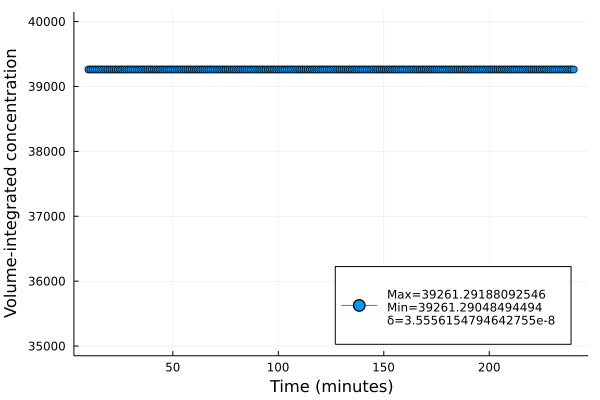

In [76]:
#file = jldopen(simulation.output_writers[:slices].filepath)
#iterations = parse.(Int, keys(file["timeseries/t"]));
#times = [file["timeseries/t/$iter"] for iter in iterations]
#intro = searchsortedfirst(times, 10minutes) # show results from 10 minutes 

# https://cn.julialang.org/JuliaZH.jl/latest/base/sort/#Base.Sort.searchsortedfirst
v_cell=zeros(1,Nz)          #cell volume 

for i in 1:Nz
    #v_cell[i]=grid.Δxᶜᵃᵃ * grid.Δyᵃᶜᵃ * grid.Δzᵃᵃᶜ[i]  # calculate cell volume 1*Nz dimension
    v_cell[i]=grid.Δxᶜᵃᵃ * grid.Δyᵃᶜᵃ * grid.Δzᵃᵃᶜ
end


t=zeros(1,length(iterations)-intro+1)
c=zeros(1,length(iterations)-intro+1)

for (i, iter) in enumerate(iterations[intro:end])
    #println((i,iter))
    t[i] = file["timeseries/t/$iter"]        
    concentration=zeros(Ny,Nz)
    for j in 1:Nx
        concentration+=file["timeseries/c/$iter"][j,:,:].*v_cell
        #add volume-integrated concentration in x plane first
    end
    c[i] = sum(concentration)  # to obtain volume-integrated concentration in whole 3D domain in one timestep

end


plot(t[:]/60,c[:],
     ylims=[35000,40000],   
     marker = :circle,
     legend=:bottomright,
     ylabel = "Volume-integrated concentration",
     xlabel = "Time (minutes)",
     #label = @printf("Max: %.5d, Min: %d, δ: %.6e ", maximum(c),minimum(c),(maximum(c)-minimum(c))/minimum(c) ))
     label = " Max=$(maximum(c)) \n Min=$(minimum(c)) \n δ=$((maximum(c)-minimum(c))/minimum(c)) ")

In [77]:
v_cell

1×24 Matrix{Float64}:
 5.33333  5.33333  5.33333  5.33333  …  5.33333  5.33333  5.33333  5.33333

## u_rms, v_rms, w_rms

In [78]:
concentration=zeros(Nz,length(iterations[intro:end]));

anim2 = @animate for (i, iter) in enumerate(iterations[intro:end])

    #@info "Drawing frame $i from iteration $iter..."

    t = file["timeseries/t/$iter"]
    u_end=file["timeseries/u/$iter"]
    v_end=file["timeseries/v/$iter"]
    w_end=file["timeseries/w/$iter"]
    c_end=file["timeseries/c/$iter"]
    
    u_avg=mean(u_end,dims=(1,2))
    v_avg=mean(v_end,dims=(1,2))
    w_avg=mean(w_end,dims=(1,2))
    c_avg=mean(c_end,dims=(1,2))
    
    u_prime=zeros(Nx,Ny,Nz)
    v_prime=zeros(Nx,Ny,Nz)
    w_prime=zeros(Nx,Ny,Nz)  #its dimension is actually Nx Ny Nz+1
    
    for k in 1:Nz
        u_prime[:,:,k]=u_end[:,:,k].-u_avg[k]  #broadcast array.-scalar 
        v_prime[:,:,k]=v_end[:,:,k].-v_avg[k]
        w_prime[:,:,k]=w_end[:,:,k].-w_avg[k]
    end
    u_rms=(mean((u_end-u_prime).^2,dims=(1,2))).^0.5
    v_rms=(mean((v_end-v_prime).^2,dims=(1,2))).^0.5
    w_rms=(mean((w_end[:,:,1:Nz]-v_prime).^2,dims=(1,2))).^0.5;
    
    #=
    plot(u_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "uᵣₘₛ",
        ylabel = "Depth (m)",
        xlabel = "Velocities (ms⁻¹)",
        xlims = (0,0.3),
        title = @sprintf("RMS velocities (ms⁻¹), t = %s", prettytime(t)))    
    plot!(v_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "vᵣₘₛ")
    plot!(w_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "wᵣₘₛ")
    =#
    
    RMS=plot(u_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "uᵣₘₛ",
        ylabel = "Depth (m)",
        xlabel = "Velocities (ms⁻¹)",
        xlims = (0,0.3),
        title = @sprintf("RMS velocities (ms⁻¹), t = %s", prettytime(t)))    
    RMS = plot!(v_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "vᵣₘₛ")
    RMS = plot!(w_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "wᵣₘₛ")
    concen=plot(c_avg[:],model.grid.zᵃᵃᶜ[1:Nz],
        label = "concentration",
        ylabel = "Depth (m)",
        xlabel = "Mean concentration",
        xlims=(0,1))
    plot(RMS, concen, layout=(1, 2), size=(900, 500),legend=:bottomright)
    concentration[:,i]=c_avg[1,1,:]
    
end


#=

  Average(field; dims=:)

  Return Reduction representing a spatial average of field over dims.

  Over regularly-spaced dimensions this is equivalent to a numerical mean!.

  Over dimensions of variable spacing, field is multipled by the appropriate grid length, area
  or volume, and divided by the total spatial extent of the interval.

=#

Animation("/tmp/jl_ntMXeC", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000222.png", "000223.png", "000224.png", "000225.png", "000226.png", "000227.png", "000228.png", "000229.png", "000230.png", "000231.png"])

In [79]:
gif(anim2, "rms_velocity.mp4", fps = 8)  # https://docs.juliaplots.org/latest/animations/

┌ Info: Saved animation to 
│   fn = /home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/rms_velocity.mp4
└ @ Plots /home/sichen/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/rms_velocity.mp4")

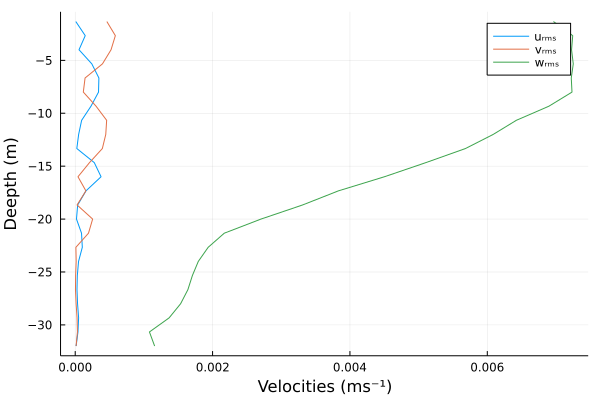

In [80]:
u_end=file["timeseries/u/$(iterations[end])"]
v_end=file["timeseries/v/$(iterations[end])"]
w_end=file["timeseries/w/$(iterations[end])"]

u_avg=mean(u_end,dims=(1,2));
v_avg=mean(v_end,dims=(1,2));
w_avg=mean(w_end,dims=(1,2));

u_prime=zeros(Nx,Ny,Nz)
v_prime=zeros(Nx,Ny,Nz)
w_prime=zeros(Nx,Ny,Nz)  #its dimension is actually Nx Ny Nz+1
for k in 1:Nz
    u_prime[:,:,k]=u_end[:,:,k].-u_avg[k]  #broadcast array.-scalar 
    v_prime[:,:,k]=v_end[:,:,k].-v_avg[k]
    w_prime[:,:,k]=w_end[:,:,k].-w_avg[k]
end

u_rms=(mean((u_end-u_prime).^2,dims=(1,2))).^0.5
v_rms=(mean((v_end-v_prime).^2,dims=(1,2))).^0.5
w_rms=(mean((w_end[:,:,1:Nz]-v_prime).^2,dims=(1,2))).^0.5;

plot(u_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "uᵣₘₛ",
     ylabel = "Deepth (m)",
     xlabel = "Velocities (ms⁻¹)")
plot!(v_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "vᵣₘₛ")
plot!(w_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "wᵣₘₛ")

#close(file)